The topic of my research project is investigating the morphology of the stellar remnant of the Milky Way + M31 major merger.

Specifically, I will investigate the question of if the 3D structure of the remnant is a spheroid or if it has some elongation or triaxiality, and how this shape changes as a function of radius.

In [2]:
# import modules and previously made code

# general modules for 
import numpy as np # math
import matplotlib.pyplot as plt # plotting
import astropy.units as u # units
from matplotlib.colors import LogNorm # histograms
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar placement
# for elliptical isophote fitting
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
# previously made code for
from CenterOfMass2 import CenterOfMass # finding center of mass (from HW6)
from RotateFrame import RotateFrame # for aligning the galaxy's angular momentum with the z axis (Lab 7)
from GalaxyMass import ComponentMass # for finding the total disk and bulge masses
from COM_calc import COM_of_COMs # for finding the COM of two COMs
from ellipse_fitting import fit_ellipse_isophote, get_closest_ellipses # for fitting elliptical isophotes
# for dealing with the geometrical properties of fitted isophotes
from ellipse_fit_geometry import get_geom_properties, get_specific_axis_lengths, get_3D_axis_length, triaxiality_param

In [3]:
# find the disk+bulge COM of each galaxy individually
# choose voldec=2 for COM position determination for
# consistency with previous HWs
# 2 = disk, 3 = bulge

# use high-resolution snapshots 2 Gyr post-MW-M31 merger (snap number 595)

# MW first
# disk COM position, velocity & mass
MW_COM_disk = CenterOfMass('MW_595.txt', 2)
MW_COM_disk_p = MW_COM_disk.COM_P(2)
MW_COM_disk_v = MW_COM_disk.COM_V(MW_COM_disk_p[0], MW_COM_disk_p[1],
                                  MW_COM_disk_p[2])
MW_disk_M = ComponentMass('MW_595.txt', 'Disk')*1e12 # put it in units of Msun

# bulge COM position, velocity & mass
MW_COM_bulge = CenterOfMass('MW_595.txt', 3)
MW_COM_bulge_p = MW_COM_bulge.COM_P(2)
MW_COM_bulge_v = MW_COM_bulge.COM_V(MW_COM_bulge_p[0], MW_COM_bulge_p[1],
                                    MW_COM_bulge_p[2])
MW_bulge_M = ComponentMass('MW_595.txt', 'Bulge')*1e12

# calculate COM position & velocity of disk & bulge COMs & total baryonic mass
MW_COM_p = COM_of_COMs(MW_COM_disk_p, MW_COM_bulge_p, MW_disk_M, MW_bulge_M)
MW_COM_v = COM_of_COMs(MW_COM_disk_v, MW_COM_bulge_v, MW_disk_M, MW_bulge_M)
MW_M = MW_disk_M + MW_bulge_M

In [4]:
# look at results
print(f'MW COM position: {MW_COM_p}')
print(f'MW COM velocity: {MW_COM_v}')
print(f'MW total mass: {MW_M:.2e}')

MW COM position: [100.63176471  88.87941176  75.30117647] kpc
MW COM velocity: [ 33.95941176 -24.80058824  31.30941176] km / s
MW total mass: 8.50e+10 solMass


In [5]:
# now M31
# disk COM position, velocity & mass
M31_COM_disk = CenterOfMass('M31_595.txt', 2)
M31_COM_disk_p = M31_COM_disk.COM_P(2)
M31_COM_disk_v = M31_COM_disk.COM_V(M31_COM_disk_p[0], M31_COM_disk_p[1],
                                  M31_COM_disk_p[2])
M31_disk_M = ComponentMass('M31_595.txt', 'Disk')*1e12 # put it in units of Msun

# bulge COM position, velocity & mass
M31_COM_bulge = CenterOfMass('M31_595.txt', 3)
M31_COM_bulge_p = M31_COM_bulge.COM_P(2)
M31_COM_bulge_v = M31_COM_bulge.COM_V(M31_COM_bulge_p[0], M31_COM_bulge_p[1],
                                    M31_COM_bulge_p[2])
M31_bulge_M = ComponentMass('M31_595.txt', 'Bulge')*1e12

# calculate COM position & velocity of disk & bulge COMs
M31_COM_p = COM_of_COMs(M31_COM_disk_p, M31_COM_bulge_p, M31_disk_M, M31_bulge_M)
M31_COM_v = COM_of_COMs(M31_COM_disk_v, M31_COM_bulge_v, M31_disk_M, M31_bulge_M)
M31_M = M31_disk_M + M31_bulge_M

In [6]:
print(f'M31 COM position: {M31_COM_p}')
print(f'M31 COM velocity: {M31_COM_v}')
print(f'M31 total mass: {M31_M:.2e}')

M31 COM position: [99.92381295 89.25985612 74.3842446 ] kpc
M31 COM velocity: [ 35.3452518  -27.07935252  31.92273381] km / s
M31 total mass: 1.39e+11 solMass


In [7]:
# now calculate COM position & velocity of whole remnant
rem_COM_p = COM_of_COMs(MW_COM_p, M31_COM_p, MW_M, M31_M)
rem_COM_v = COM_of_COMs(MW_COM_v, M31_COM_v, MW_M, M31_M)

print(f'Remnant COM position: {rem_COM_p}')
print(f'Remnant COM velocity: {rem_COM_v}')
# it's closer to the position and velocity of M31, which makes sense
# although MW and M31 were already very close to each other (again, makes sense)

Remnant COM position: [100.19245536  89.11549107  74.7321875 ] kpc
Remnant COM velocity: [ 34.819375   -26.21464286  31.69      ] km / s


In [8]:
# "make" the remnant 

# concatenate MW and M31 bulge & disk arrays into one
# for position
# x, y, z individually for now
rem_x = np.concatenate((MW_COM_disk.x, MW_COM_bulge.x, 
                        M31_COM_disk.x, M31_COM_bulge.x),
                        axis=0)
rem_y = np.concatenate((MW_COM_disk.y, MW_COM_bulge.y, 
                        M31_COM_disk.y, M31_COM_bulge.y),
                        axis=0)
rem_z = np.concatenate((MW_COM_disk.z, MW_COM_bulge.z, 
                        M31_COM_disk.z, M31_COM_bulge.z),
                        axis=0)

# now subtract COM position from remnant position arrays
rem_x_rel = rem_x - rem_COM_p[0].value
rem_y_rel = rem_y - rem_COM_p[0].value
rem_z_rel = rem_z - rem_COM_p[0].value

# and get final remnant position array relative to its COM
rem_p_rel = np.array([rem_x_rel, rem_y_rel, rem_z_rel])*u.kpc

In [9]:
# do the same for velocity
# get individual vx, vy, viz
rem_vx = np.concatenate((MW_COM_disk.vx, MW_COM_bulge.vx, 
                        M31_COM_disk.vx, M31_COM_bulge.vx),
                        axis=0)
rem_vy = np.concatenate((MW_COM_disk.vy, MW_COM_bulge.vy, 
                        M31_COM_disk.vy, M31_COM_bulge.vy),
                        axis=0)
rem_vz = np.concatenate((MW_COM_disk.vz, MW_COM_bulge.vz, 
                        M31_COM_disk.vz, M31_COM_bulge.vz),
                        axis=0)

# get velocity components relative to COM
rem_vx_rel = rem_vx - rem_COM_v[0].value
rem_vy_rel = rem_vy - rem_COM_v[0].value
rem_vz_rel = rem_vz - rem_COM_v[0].value

# get total velocity array
rem_v_rel = np.array([rem_vx_rel, rem_vy_rel, rem_vz_rel])*u.km/u.s

In [10]:
# align the remnant's angular momentum with the z-axis
# this will allow me to look at it "edge-on" and "face-on"
rem_p, rem_v = RotateFrame(rem_p_rel.T, rem_v_rel.T)

In [11]:
# make 2d particle density histograms of each projection
# xy, xz, and yz
xyhist = np.histogram2d(rem_p[:,0].value, rem_p[:,1].value, 
              bins=1000)
xzhist = np.histogram2d(rem_p[:,0].value, rem_p[:,2].value, 
              bins=1000)
yzhist = np.histogram2d(rem_p[:,1].value, rem_p[:,2].value, 
              bins=1000)

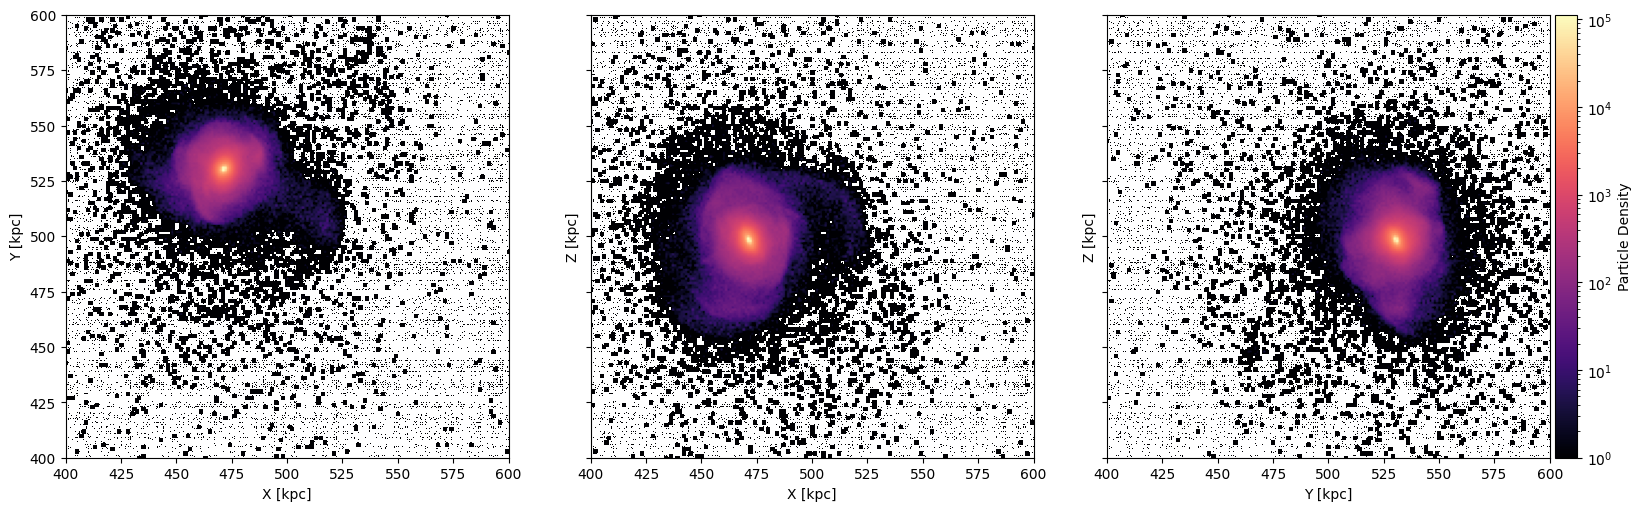

In [35]:


fig, axs = plt.subplots(1,3, figsize=(16,5), sharex=True, 
                        sharey=True, layout='constrained')

# get a common vmin and vmax for the histograms
# so the same colorbar works for all 3
# get maximum and minimum particle densities
# concatenate all the histograms for this real quick
tempdens = np.concatenate((xyhist[0], xzhist[0], yzhist[0]))
vmax = np.max(tempdens)
# have to find minimum NONZERO density for vmin
# because LogNorm() doesn't take arguments <= 0
vmin = np.min(tempdens[np.nonzero(tempdens)])

# actually plot everything
# xy
# particle density histogram
# transpose it so imshow shows it correctly
axs[0].imshow(xyhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# axis labels
axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')

# xz
# particle density histogram
axs[1].imshow(xzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# axis labels
axs[1].set_xlabel('X [kpc]')
axs[1].set_ylabel('Z [kpc]')

# yz
# particle density histogram
# save this 2d histogram for making the colorbar
im = axs[2].imshow(yzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# axis labels
axs[2].set_xlabel('Y [kpc]')
axs[2].set_ylabel('Z [kpc]')

# set global axis limits
fig.gca().set_xlim(400, 600)
fig.gca().set_ylim(400, 600)

# make a common colorbar for all 3 plots
# make an "axis" for the new colorbar
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
# add colorbar
fig.colorbar(im, cax=cax, label='Particle Density')

In [14]:
# get elliptical fits for all the projections
xy_ellipses = fit_ellipse_isophote(xyhist, 50, 0, 0)
yz_ellipses = fit_ellipse_isophote(yzhist, 50, 0, 0)
xz_ellipses = fit_ellipse_isophote(xzhist, 50, 0, 0)

In [15]:
# get binsizes for histograms so I can convert back to kpc when needed
xy_binsize = xyhist[1][1] - xyhist[1][0]
xz_binsize = xzhist[1][1] - xzhist[1][0]
yz_binsize = yzhist[1][1] - yzhist[1][0]

In [16]:
# define an array of semimajor axes of interest
# use a log scale because the galaxy's density changes 
# most closer to the center

# in kpc
sma_arr = np.linspace(10, 150, 25)

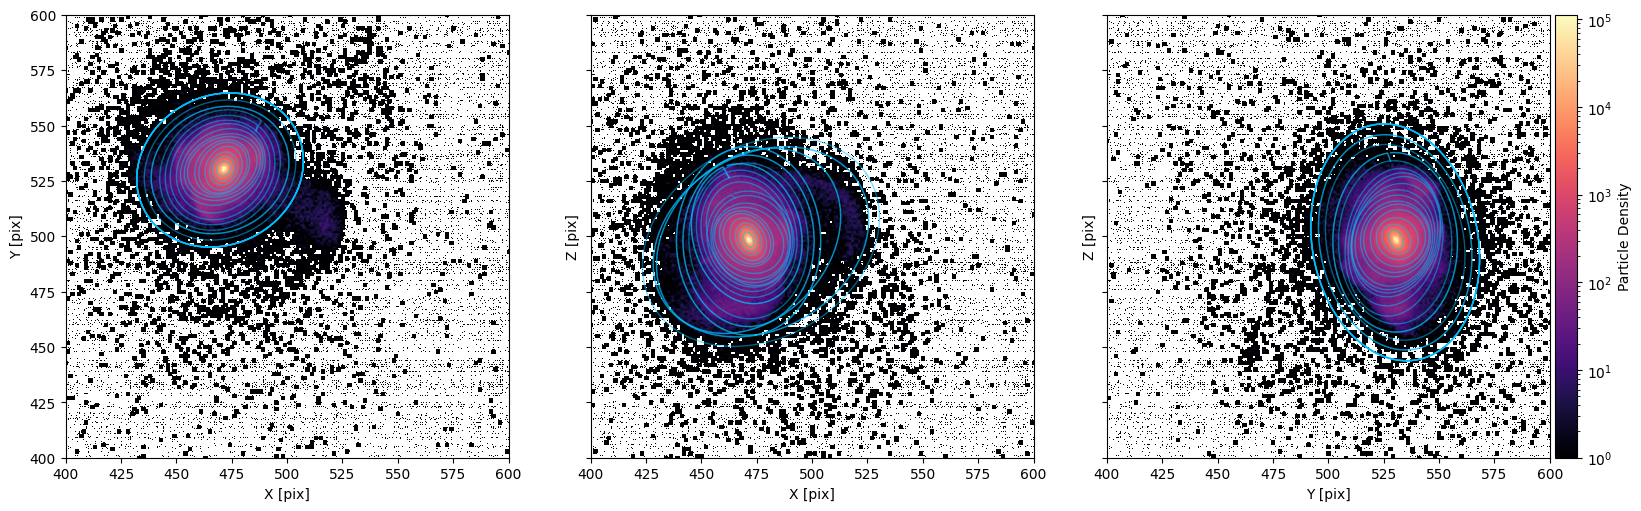

In [17]:
# get and plot best-fit ellipses to these semimajor axes

fig, axs = plt.subplots(1,3, figsize=(16,5), sharex=True, 
                        sharey=True, layout='constrained')

# define parameters for the ellipses
color = 'deepskyblue'
lw = 1

# xy
# particle density histogram
axs[0].imshow(xyhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
xy_fitells = get_closest_ellipses(sma_arr, xy_ellipses, xy_binsize, ax=axs[0], 
                                  color=color, linewidth=lw, alpha=0.5)

# axis labels
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# xz
# particle density histogram
axs[1].imshow(xzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
xz_fitells = get_closest_ellipses(sma_arr, xz_ellipses, xz_binsize, ax=axs[1], 
                                  color=color, linewidth=lw, alpha=0.5)
# axis labels
axs[1].set_xlabel('X [pix]')
axs[1].set_ylabel('Z [pix]')

axs[0].set_xlim(400, 600)
axs[0].set_ylim(400, 600)

# yz
# particle density histogram
# save this 2d histogram for making the colorbar
im = axs[2].imshow(yzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
yz_fitells = get_closest_ellipses(sma_arr, yz_ellipses, yz_binsize, ax=axs[2], 
                                  color=color, linewidth=lw, alpha=0.5)
# axis labels
axs[2].set_xlabel('Y [pix]')
axs[2].set_ylabel('Z [pix]')

# make a common colorbar for all 3 plots
# make an "axis" for the new colorbar
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
# add colorbar
fig.colorbar(im, cax=cax, label='Particle Density')

In [18]:
# get semimajor axis, semiminor axis, position angle, 
# and ellipticity for each elliptical fit in each projection

# xy
xy_geom_params = np.array(get_geom_properties(xy_fitells))
# xz
xz_geom_params = np.array(get_geom_properties(xz_fitells))
# yz
yz_geom_params = np.array(get_geom_properties(yz_fitells))

Text(0, 0.5, 'Ellipticity $\\epsilon$')

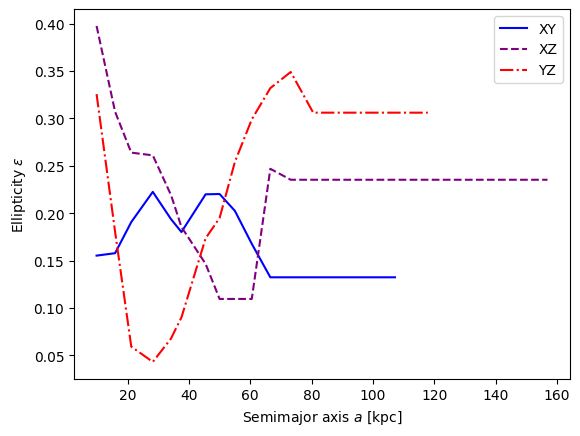

In [19]:
# plot ellipticity vs. semimajor axis for each projection
# just to see how far out ellipses are actually being fit
# convert semimajor axis back to kpc!

fig, ax = plt.subplots()

# xy
ax.plot(xy_geom_params[0]*xy_binsize, xy_geom_params[3], 
        c='b', label='XY')
# xz
ax.plot(xz_geom_params[0]*xz_binsize, xz_geom_params[3], 
        c='purple', linestyle='--', label='XZ')
# yz
ax.plot(yz_geom_params[0]*yz_binsize, yz_geom_params[3], 
        c='r', linestyle='-.', label='YZ')

ax.legend()

ax.set_xlabel(r'Semimajor axis $a$ [kpc]')
ax.set_ylabel(r'Ellipticity $\epsilon$')

# seems like after ~75 kpc fits just weren't being made anymore

In [20]:
# cut off where xy projection begins to flatten out
# so I'm comparing apples to apples

In [ ]:
# get first index where semimajor axis hits ~75 kpc (38 pix)
idx = np.where(xy_geom_params[0]>38)[0][0]

# and trim the arrays accordingly
xy_geom_params = xy_geom_params[:,:idx+1]
xz_geom_params = xz_geom_params[:,:idx+1]
yz_geom_params = yz_geom_params[:,:idx+1]

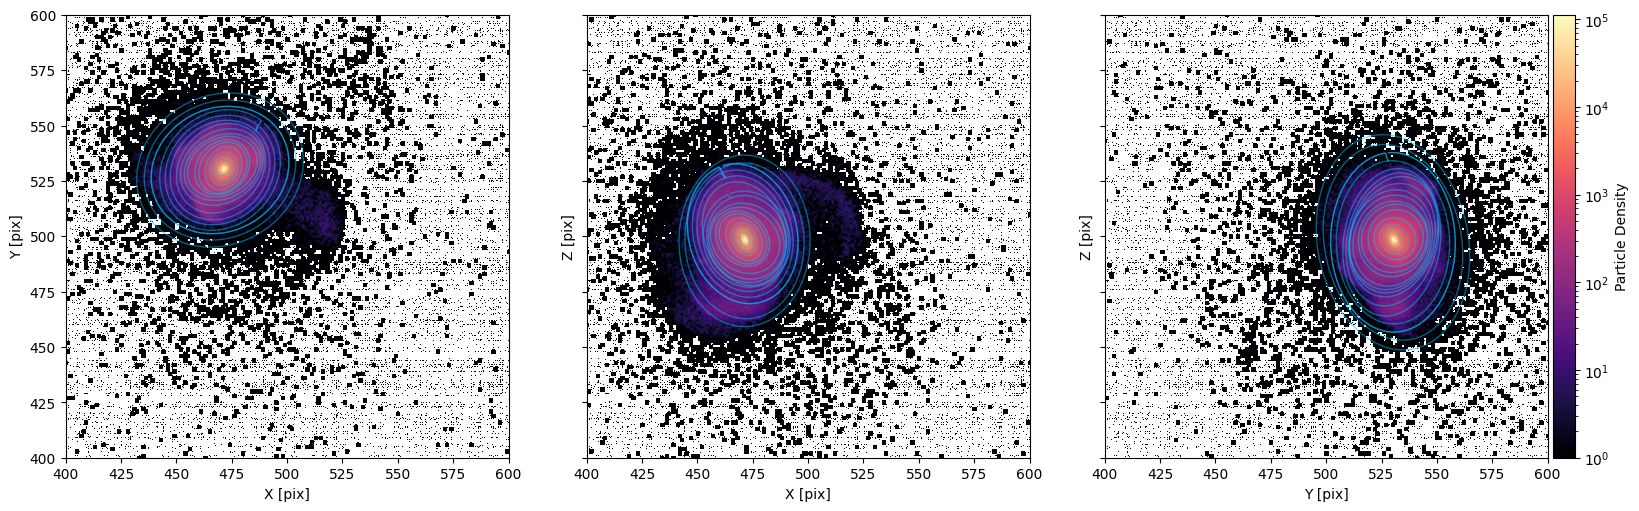

In [37]:
# replot just the best-fit ellipses I'm using

fig, axs = plt.subplots(1,3, figsize=(16,5), sharex=True, 
                        sharey=True, layout='constrained')

# define parameters for the ellipses
color = 'deepskyblue'
lw = 1

# xy
# particle density histogram
axs[0].imshow(xyhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
for ellipse in xy_fitells[:idx+1]:
        x_ell, y_ell = ellipse.sampled_coordinates()
        axs[0].plot(x_ell, y_ell, color=color, linewidth=lw, alpha=0.5)

# axis labels
axs[0].set_xlabel('X [pix]')
axs[0].set_ylabel('Y [pix]')

# xz
# particle density histogram
axs[1].imshow(xzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
for ellipse in xz_fitells[:idx+1]:
        x_ell, y_ell = ellipse.sampled_coordinates()
        axs[1].plot(x_ell, y_ell, color=color, linewidth=lw, alpha=0.5)
# axis labels
axs[1].set_xlabel('X [pix]')
axs[1].set_ylabel('Z [pix]')

axs[0].set_xlim(400, 600)
axs[0].set_ylim(400, 600)

# yz
# particle density histogram
# save this 2d histogram for making the colorbar
im = axs[2].imshow(yzhist[0].T, norm=LogNorm(vmin=vmin, vmax=vmax), 
              cmap='magma', origin='lower')
# ellipses
for ellipse in yz_fitells[:idx+1]:
        x_ell, y_ell = ellipse.sampled_coordinates()
        axs[2].plot(x_ell, y_ell, color=color, linewidth=lw, alpha=0.5)
# axis labels
axs[2].set_xlabel('Y [pix]')
axs[2].set_ylabel('Z [pix]')

# make a common colorbar for all 3 plots
# make an "axis" for the new colorbar
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
# add colorbar
fig.colorbar(im, cax=cax, label='Particle Density')

# save figure
fig.savefig("ellipse_fits.png", bbox_inches='tight')

In [22]:
# time to determine the 3D shapes!

In [ ]:
# get specific axes for all projections
xy_spec_axes = get_specific_axis_lengths(xy_geom_params, xy_binsize)
xz_spec_axes = get_specific_axis_lengths(xz_geom_params, xz_binsize)
yz_spec_axes = get_specific_axis_lengths(yz_geom_params, yz_binsize)

In [ ]:
# get specific axis lengths of fitted ellipsoids
n = len(xy_geom_params[0])
x_axes, y_axes, z_axes = np.zeros(n), np.zeros(n), np.zeros(n)

for i in range(n):

    # NOTE: for the vertical axis, add pi/2 to the angle!

    # find x-axis length from xy & xz
    x_ax = get_3D_axis_length([xy_spec_axes[0][i], xz_spec_axes[0][i]],
                              [xy_geom_params[3][i], xz_geom_params[3][i]],
                              ['xy', 'xz'])
    x_axes[i] = x_ax
    
    # find y-axis length from xy & yz
    y_ax = get_3D_axis_length([xy_spec_axes[1][i], yz_spec_axes[0][i]],
                              [xy_geom_params[3][i]+np.pi/2, yz_geom_params[3][i]],
                              ['xy', 'yz'])
    y_axes[i] = y_ax

    # find y-axis length from xy & yz
    z_ax = get_3D_axis_length([xz_spec_axes[1][i], yz_spec_axes[1][i]],
                              [xz_geom_params[3][i]+np.pi/2, yz_geom_params[3][i]+np.pi/2],
                              ['xz', 'yz'])
    z_axes[i] = z_ax

In [ ]:
ell_axes = np.array([x_axes, y_axes, z_axes])
T, q1, q2 = triaxiality_param(ell_axes)

In [ ]:
# get the largest axis for each ellipsoid fit
axes_3D = np.array([x_axes, y_axes, z_axes])
sma3D_arr = np.max(axes_3D, axis=0)

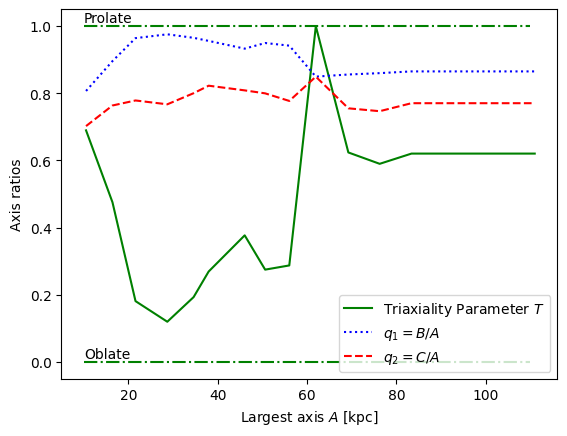

In [38]:
# plot axis ratios along with triaxiality parameter

fig, ax = plt.subplots()


# triaxiality parameter T
ax.plot(sma3D_arr, T, c="g",
        label="Triaxiality Parameter $T$")
# q1 = B/A
ax.plot(sma3D_arr, q1, c='b',
        linestyle=':', label=r'$q_1 = B/A$')
# q2 = C/A
ax.plot(sma3D_arr, q2, c='r', 
        linestyle='--', label=r'$q_2 = C/A$')

# prolate & oblate limits of T
ax.hlines([1,0], 10, 110, colors='g', 
          linestyles='-.')
ax.annotate('Prolate', (10, 1.01))
ax.annotate('Oblate', (10, 0.01))

ax.set_xlabel(r"Largest axis $A$ [kpc]")
ax.set_ylabel(r'Axis ratios')
ax.legend()

fig.savefig("axis_ratios.png", bbox_inches='tight')